# Import Libraries 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import gc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Explore Data

In [12]:
dataset_path = "AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")


CSV file saved as dataset.csv


In [13]:
df.head()

,image_path,category
0,AugmentedAlzheimerDataset\MildDemented\00046ff...,MildDemented
1,AugmentedAlzheimerDataset\MildDemented\000cdcc...,MildDemented
2,AugmentedAlzheimerDataset\MildDemented\0013ad5...,MildDemented
3,AugmentedAlzheimerDataset\MildDemented\0015bdf...,MildDemented
4,AugmentedAlzheimerDataset\MildDemented\001f15e...,MildDemented


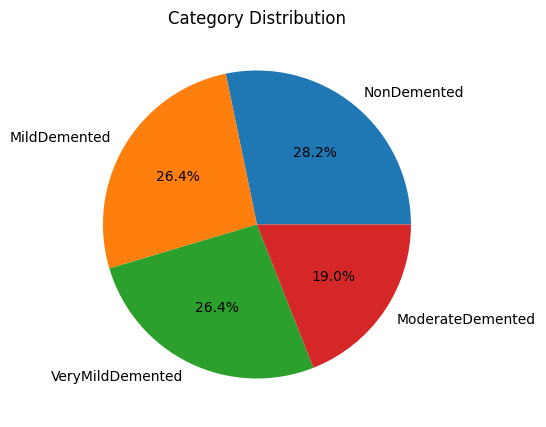

In [14]:
category_counts = df["category"].value_counts()

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

In [15]:
def show_random_images(column, number_of_images_to_show=5, grey=False):
    categories = df["category"].unique()
    
    images_per_category = number_of_images_to_show
    
    plt.figure(figsize=(15, len(categories) * 5))
    for i, category in enumerate(categories):
        category_images = df[df["category"] == category][column].tolist()
        
        for j in range(min(len(category_images), images_per_category)):
            img_data = category_images[j]
            if column != "image_path":
                img = img_data
            else:
                img = cv2.imread(img_data)
                
            if column == "image_path":
                if grey:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(categories), images_per_category, i * images_per_category + j + 1)
            
            if grey:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img)
            
            plt.axis("off")
            plt.title(f"{category}")
    
    plt.tight_layout()
    plt.show()

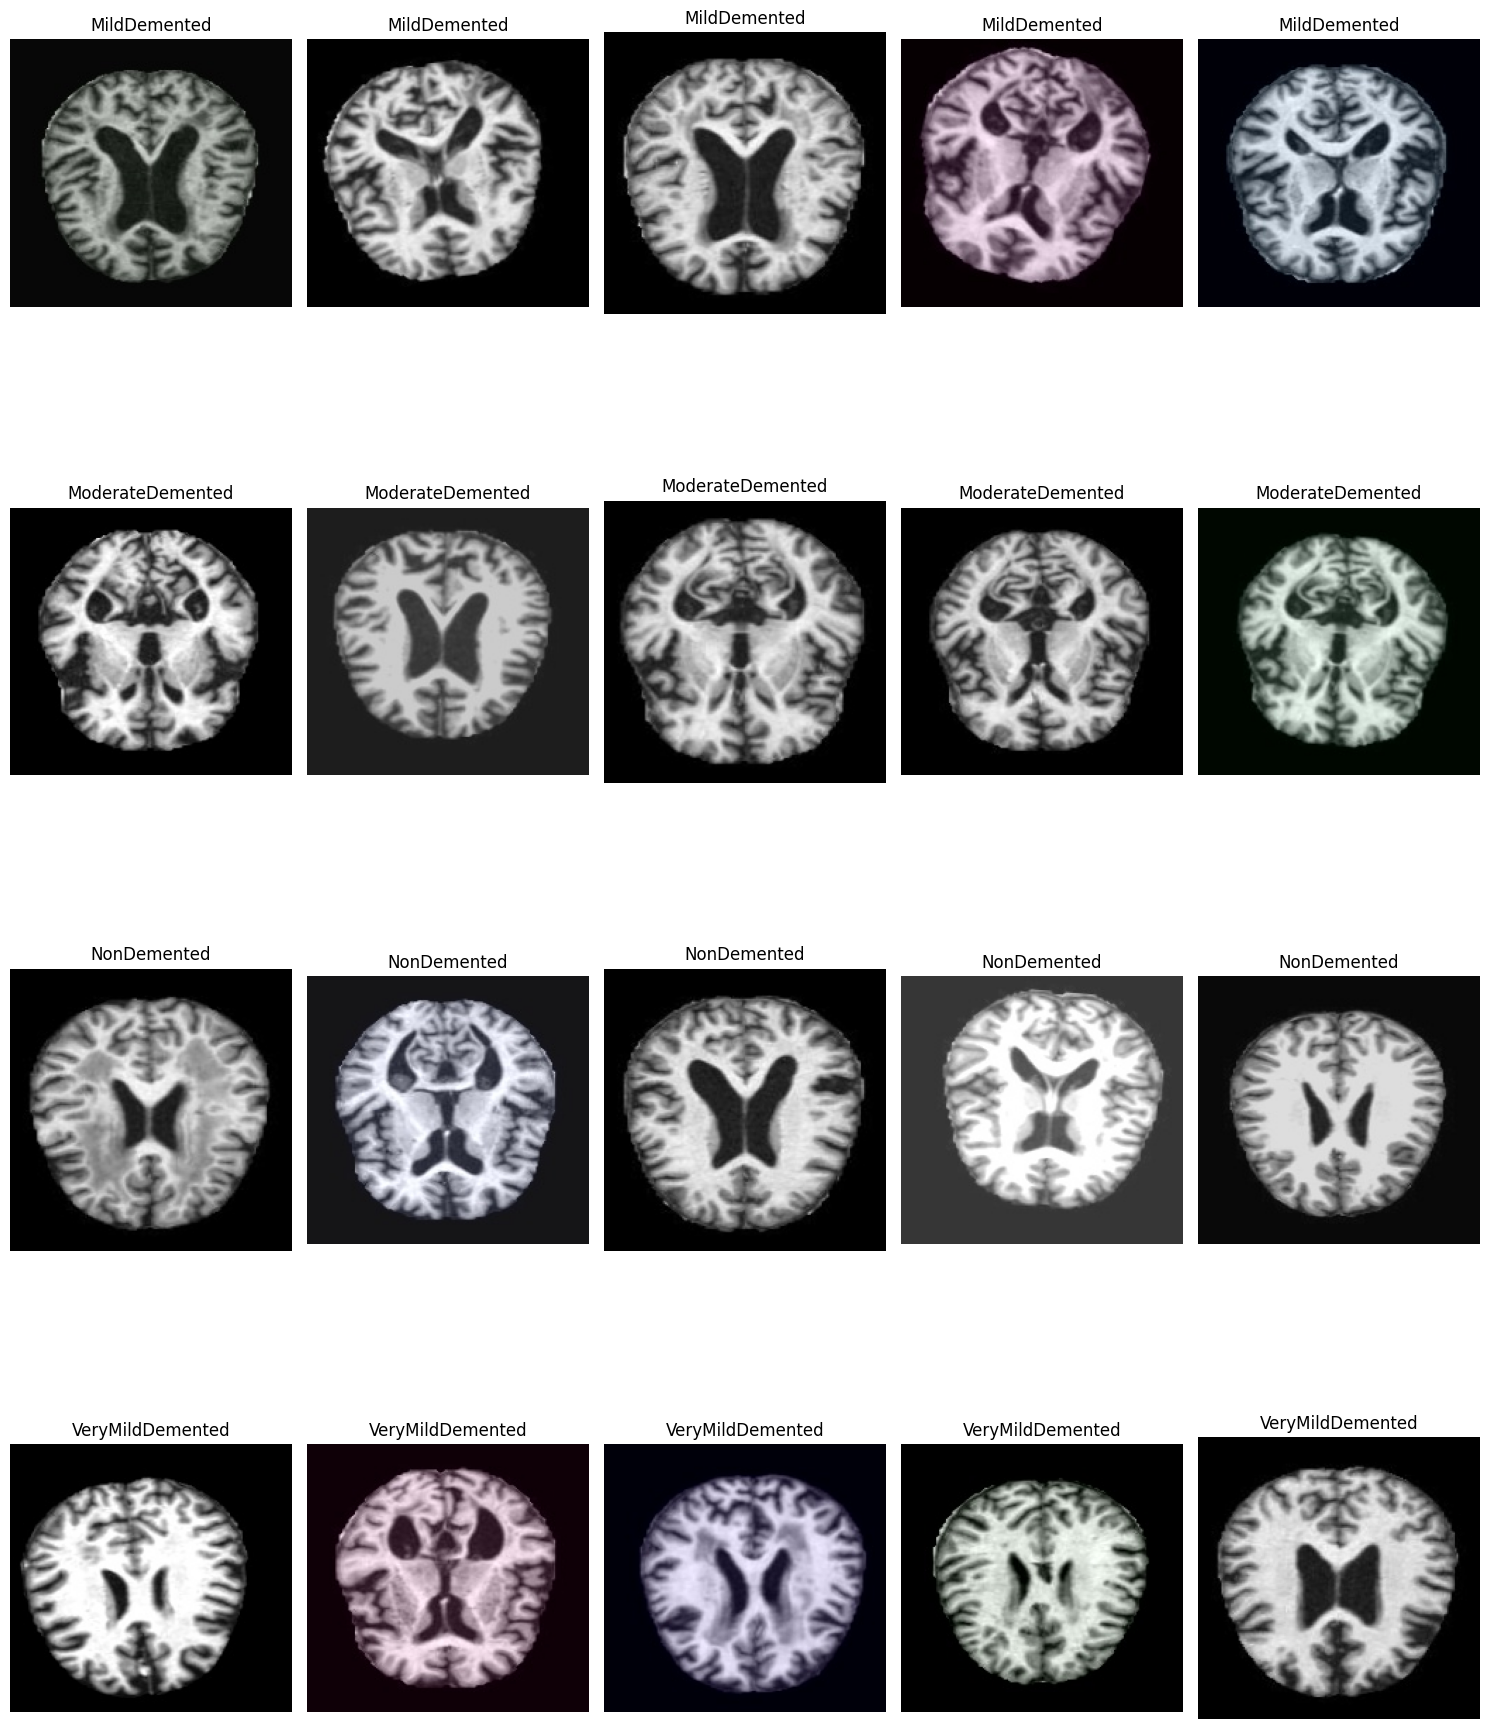

In [16]:
show_random_images("image_path", 5, False)

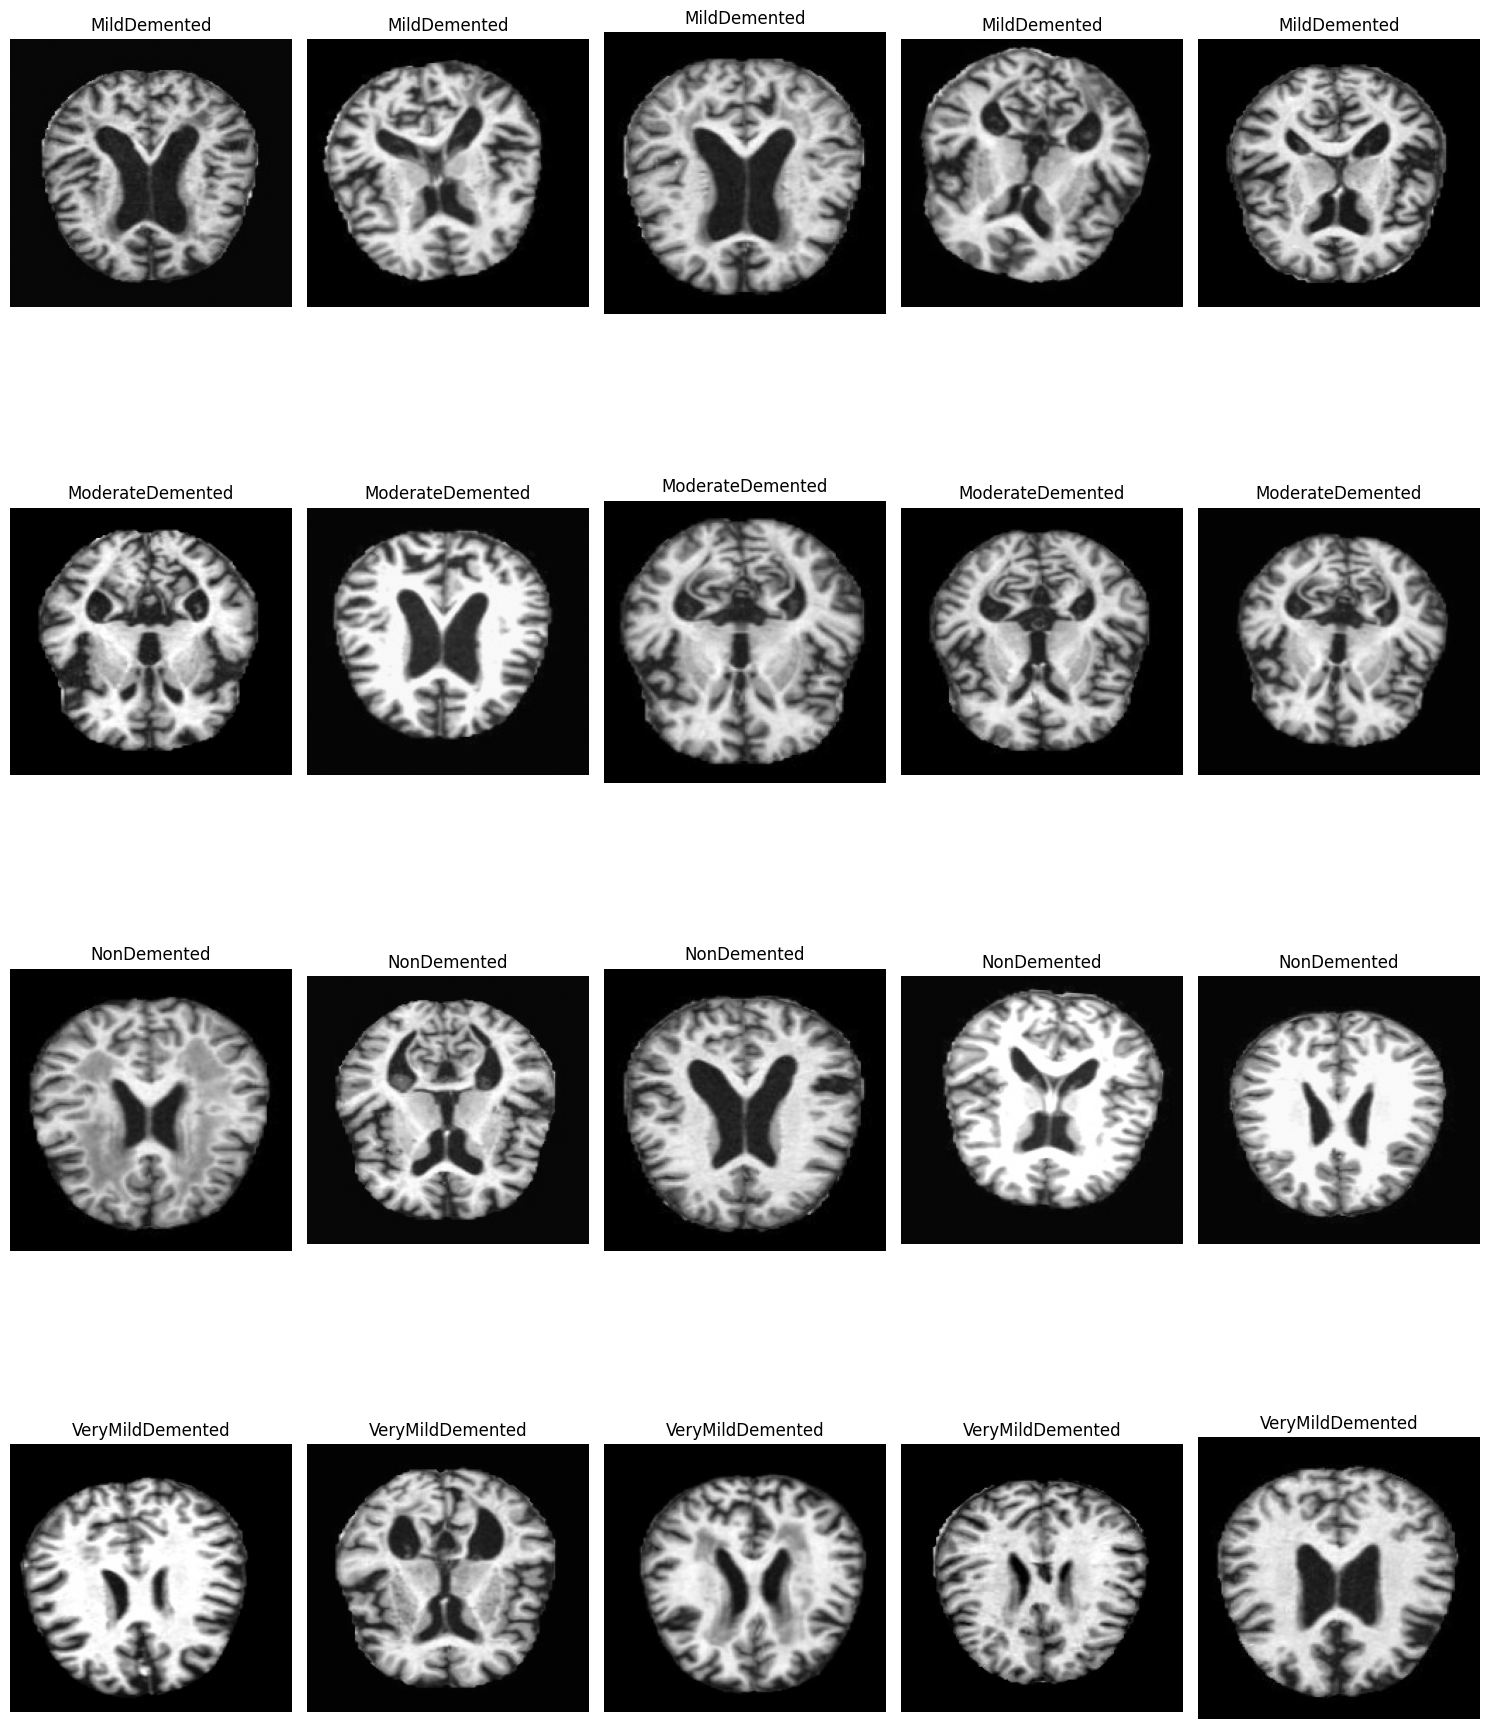

In [17]:
show_random_images("image_path",5, True)

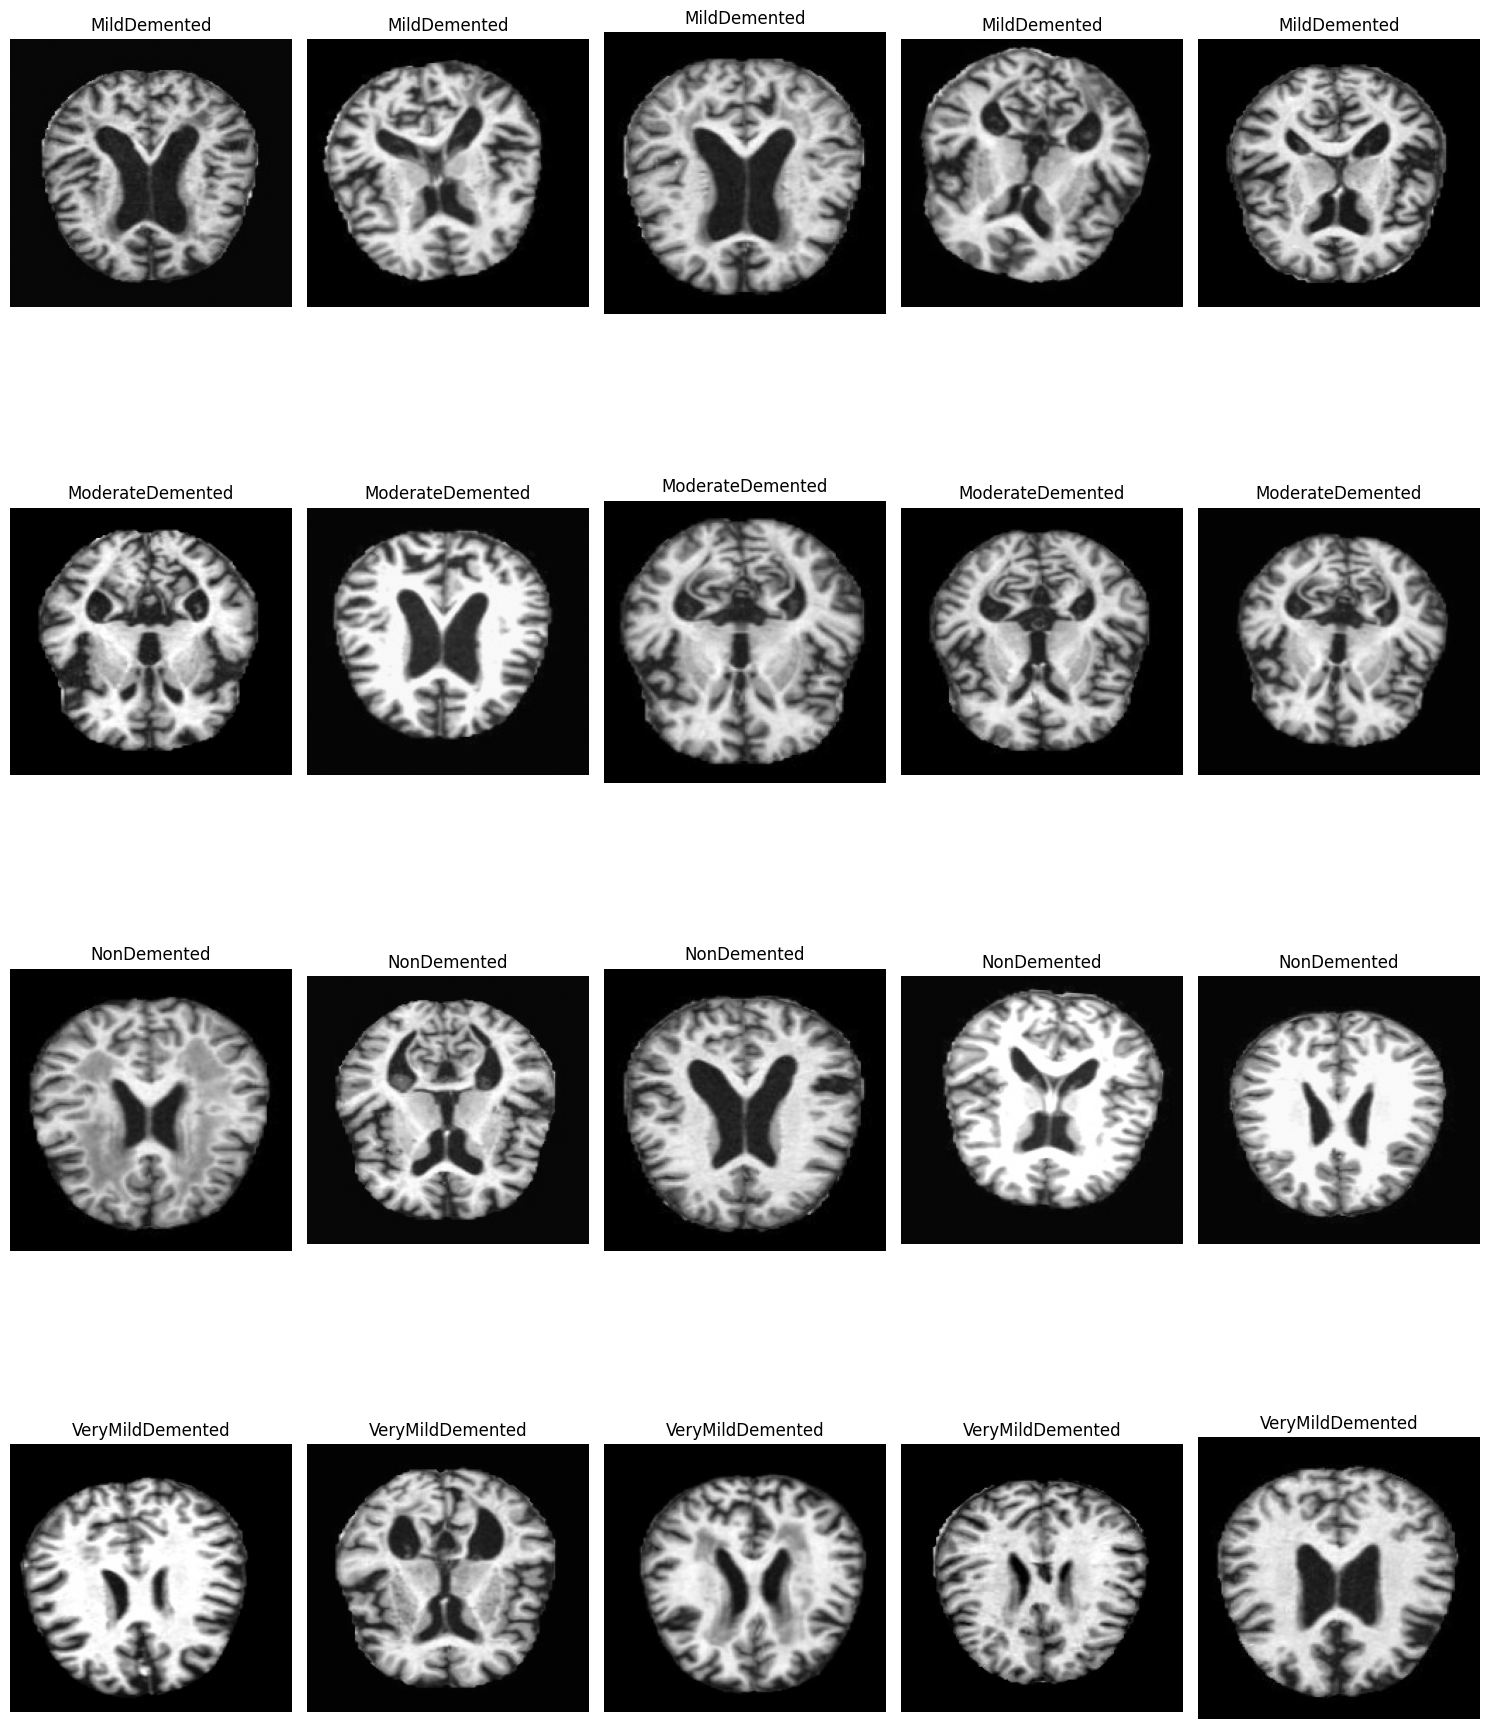

In [18]:
show_random_images("image_path",5, True)

In [19]:
dataset_path = "AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")


CSV file saved as dataset.csv


## Image Processing

In [20]:
def image_processing(img):
    img = cv2.imread(img)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_resized = cv2.resize(img_gray, (224,224))

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7,7))
    img_clahe = clahe.apply(img_resized)

    norm_img = cv2.normalize(img_clahe, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return norm_img

In [21]:
processed_image = []
for img in df['image_path']:
    processed_image.append(image_processing(img))
df['processed_image'] = processed_image
df = df.drop(columns = ['image_path'])

output_csv = "dataset_processed.csv"
df.to_csv(output_csv, index=False)

del processed_image
gc.collect()

107157

## Grouping Data

In [23]:
grouped = df.groupby('category')
for category, data in grouped:
    globals()[f"df_{category}"] = data

## Build Models(Relies on a multi-class classification model using the Convolutional Neural Network (CNN) algorithm)

In [24]:
def create_model(add_more_layers):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    if add_more_layers:
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [25]:
def create_Deep_model(add_more_layers):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    if add_more_layers:
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    if add_more_layers:
        model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Configure Data

In [26]:
def data_generator(df, batch_size):
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]

            X_batch = np.array(batch_df['processed_image'].tolist())
            Y_batch = np.array(batch_df['category'].tolist())
            
            yield X_batch, Y_batch

In [27]:
def model_train(train_df, val_df, add_more_layers, patience, use_deep_model):
    train_gen = data_generator(train_df, batch_size = 4)
    val_gen = data_generator(val_df, batch_size = 4)
    
    steps_per_epoch = len(train_df) // 4
    validation_steps = len(val_df) // 4

    model = -1

    if use_deep_model:
        model = create_Deep_model(add_more_layers)
    else:
        model = create_model(add_more_layers)
        
    model_history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_gen,
        validation_steps = validation_steps,
        epochs = 50,
        callbacks = [EarlyStopping (
        monitor = 'val_loss',
        patience = patience,
        restore_best_weights = True
        )]
    )

    return model, model_history

In [28]:
def plot_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_loss, label='Training Loss', color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='orange')
    ax1.set_title('Loss Curve')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_acc, label='Training Accuracy', color='green')
    ax2.plot(val_acc, label='Validation Accuracy', color='red')
    ax2.set_title('Accuracy Curve')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [29]:
def process_data__train_and_save_model(df, model_name, add_more_layers, patience, use_deep_model):
    df = df.sample(frac=1).reset_index(drop=True)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    model, model_history = model_train(train_df , test_df, add_more_layers, patience, use_deep_model)

    plot_curves(model_history)
    
    model.save(model_name)

## Models Training

In [30]:
train_df, df_NonDemented_test = train_test_split(df_NonDemented, test_size=0.2, random_state=42)
train_df['category'] = 1

Epoch 1/50
3072/3072 [==============================] - 150s 30ms/step - loss: 0.6989 - accuracy: 0.5871 - val_loss: 0.6231 - val_accuracy: 0.6348
Epoch 2/50
3072/3072 [==============================] - 89s 29ms/step - loss: 0.6415 - accuracy: 0.6352 - val_loss: 0.5837 - val_accuracy: 0.6872
Epoch 3/50
3072/3072 [==============================] - 89s 29ms/step - loss: 0.5937 - accuracy: 0.6866 - val_loss: 0.6959 - val_accuracy: 0.6237
Epoch 4/50
3072/3072 [==============================] - 93s 30ms/step - loss: 0.5296 - accuracy: 0.7349 - val_loss: 0.5190 - val_accuracy: 0.7406
Epoch 5/50
3072/3072 [==============================] - 88s 29ms/step - loss: 0.4665 - accuracy: 0.7808 - val_loss: 0.9077 - val_accuracy: 0.5915
Epoch 6/50
3072/3072 [==============================] - 94s 31ms/step - loss: 0.4090 - accuracy: 0.8145 - val_loss: 0.4197 - val_accuracy: 0.7842
Epoch 7/50
3072/3072 [==============================] - 99s 32ms/step - loss: 0.3666 - accuracy: 0.8396 - val_loss: 0.2909 

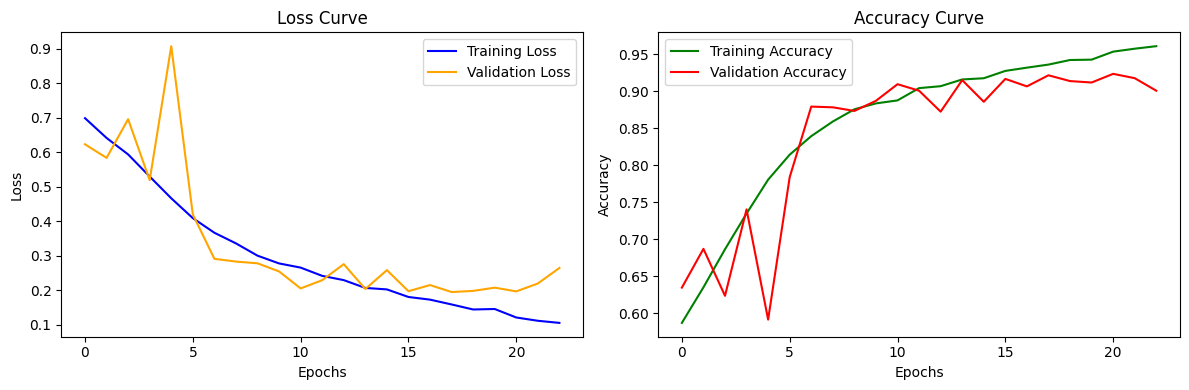

In [31]:
sampled_df = df_VeryMildDemented.sample(n = len(train_df), random_state=42)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_NonVSVeryMild.h5", True, 5, True)

Epoch 1/50
3072/3072 [==============================] - 94s 30ms/step - loss: 0.6001 - accuracy: 0.6848 - val_loss: 0.4483 - val_accuracy: 0.7923
Epoch 2/50
3072/3072 [==============================] - 87s 28ms/step - loss: 0.5227 - accuracy: 0.7479 - val_loss: 0.4288 - val_accuracy: 0.7826
Epoch 3/50
3072/3072 [==============================] - 92s 30ms/step - loss: 0.4698 - accuracy: 0.7787 - val_loss: 0.5170 - val_accuracy: 0.6956
Epoch 4/50
3072/3072 [==============================] - 91s 30ms/step - loss: 0.4265 - accuracy: 0.8097 - val_loss: 0.2697 - val_accuracy: 0.9121
Epoch 5/50
3072/3072 [==============================] - 91s 30ms/step - loss: 0.3833 - accuracy: 0.8292 - val_loss: 0.3124 - val_accuracy: 0.8551
Epoch 6/50
3072/3072 [==============================] - 87s 28ms/step - loss: 0.3550 - accuracy: 0.8464 - val_loss: 0.2739 - val_accuracy: 0.8734
Epoch 7/50
3072/3072 [==============================] - 87s 28ms/step - loss: 0.3205 - accuracy: 0.8647 - val_loss: 0.1601 -

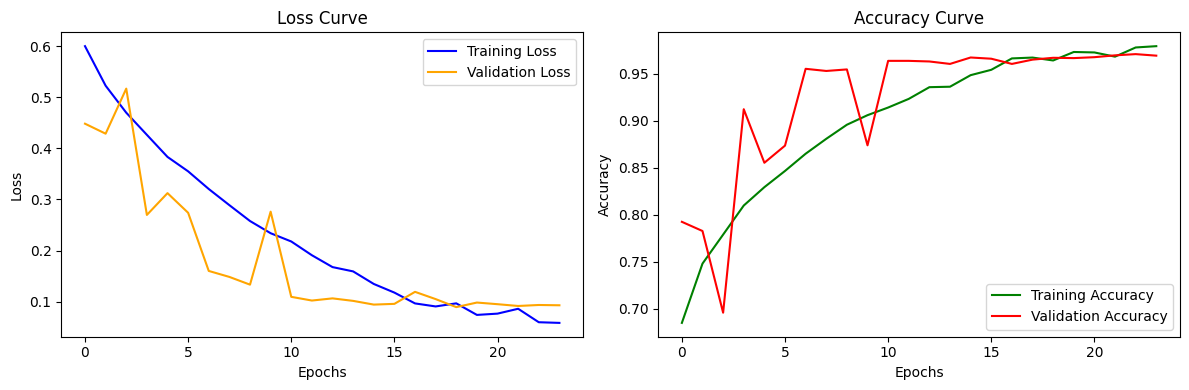

In [32]:
sampled_df = df_MildDemented.sample(n = len(train_df), random_state=42)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_NonVSMild.h5", True, 5, True)

Epoch 1/50
2828/2828 [==============================] - 51s 18ms/step - loss: 0.2121 - accuracy: 0.9043 - val_loss: 0.0393 - val_accuracy: 0.9855
Epoch 2/50
2828/2828 [==============================] - 49s 17ms/step - loss: 0.0592 - accuracy: 0.9794 - val_loss: 0.0178 - val_accuracy: 0.9947
Epoch 3/50
2828/2828 [==============================] - 49s 17ms/step - loss: 0.0367 - accuracy: 0.9863 - val_loss: 0.0188 - val_accuracy: 0.9947
Epoch 4/50
2828/2828 [==============================] - 49s 17ms/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.0345 - val_accuracy: 0.9894


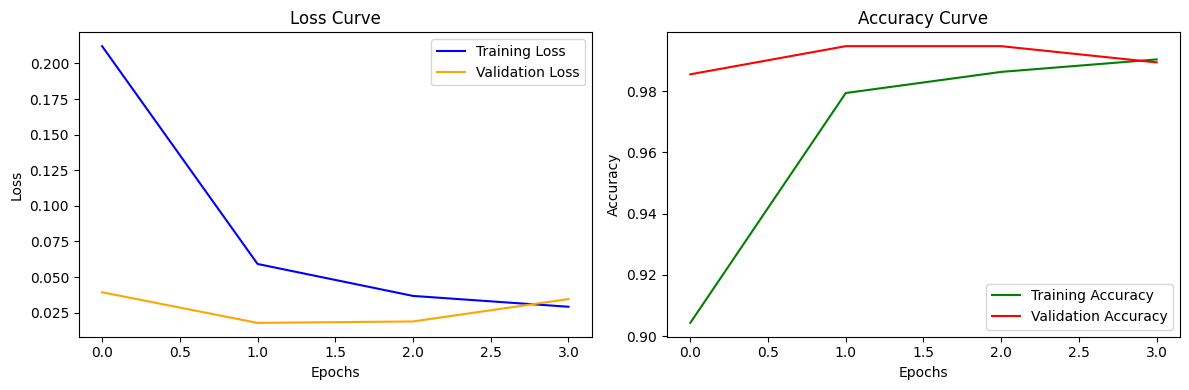

In [33]:
sampled_df = df_ModerateDemented.copy()
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_NonVSModerate.h5", False, 2, False)

In [34]:
train_df, df_VeryMildDemented_test = train_test_split(df_VeryMildDemented, test_size=0.2, random_state=42)
train_df['category'] = 1

Epoch 1/50
2867/2867 [==============================] - 91s 31ms/step - loss: 0.7088 - accuracy: 0.5929 - val_loss: 2.5713 - val_accuracy: 0.4955
Epoch 2/50
2867/2867 [==============================] - 83s 29ms/step - loss: 0.6351 - accuracy: 0.6464 - val_loss: 0.6392 - val_accuracy: 0.6796
Epoch 3/50
2867/2867 [==============================] - 88s 31ms/step - loss: 0.5615 - accuracy: 0.7151 - val_loss: 0.5050 - val_accuracy: 0.7374
Epoch 4/50
2867/2867 [==============================] - 86s 30ms/step - loss: 0.4955 - accuracy: 0.7620 - val_loss: 0.3441 - val_accuracy: 0.8309
Epoch 5/50
2867/2867 [==============================] - 82s 29ms/step - loss: 0.4406 - accuracy: 0.7952 - val_loss: 0.3008 - val_accuracy: 0.8550
Epoch 6/50
2867/2867 [==============================] - 82s 29ms/step - loss: 0.3845 - accuracy: 0.8257 - val_loss: 0.2354 - val_accuracy: 0.9086
Epoch 7/50
2867/2867 [==============================] - 79s 28ms/step - loss: 0.3650 - accuracy: 0.8372 - val_loss: 0.2384 -

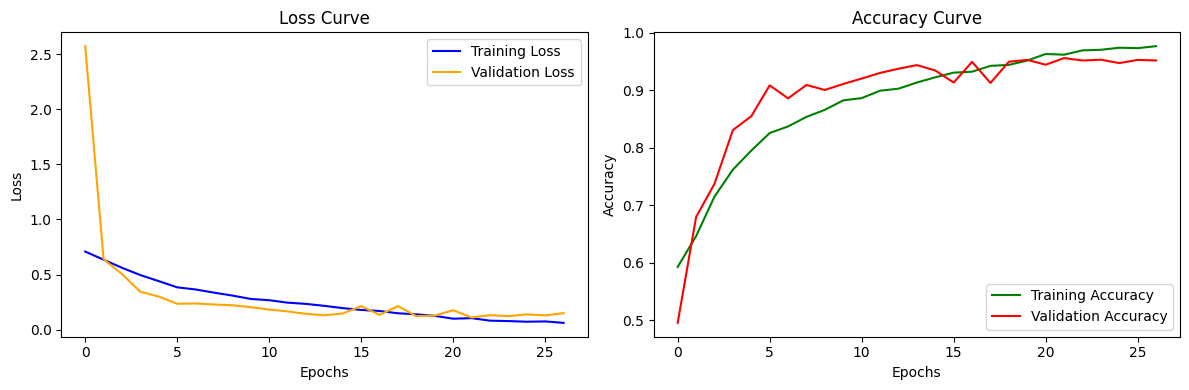

In [35]:
sampled_df = df_MildDemented.sample(n = len(train_df), random_state=42)
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_VeryMildVSMild.h5", True, 5, True)

Epoch 1/50
2726/2726 [==============================] - 50s 18ms/step - loss: 0.2600 - accuracy: 0.8803 - val_loss: 0.0591 - val_accuracy: 0.9769
Epoch 2/50
2726/2726 [==============================] - 48s 18ms/step - loss: 0.0817 - accuracy: 0.9686 - val_loss: 0.0380 - val_accuracy: 0.9831
Epoch 3/50
2726/2726 [==============================] - 48s 17ms/step - loss: 0.0425 - accuracy: 0.9834 - val_loss: 0.0187 - val_accuracy: 0.9941
Epoch 4/50
2726/2726 [==============================] - 48s 18ms/step - loss: 0.0377 - accuracy: 0.9873 - val_loss: 0.0502 - val_accuracy: 0.9835
Epoch 5/50
2726/2726 [==============================] - 48s 18ms/step - loss: 0.0245 - accuracy: 0.9916 - val_loss: 0.0132 - val_accuracy: 0.9963
Epoch 6/50
2726/2726 [==============================] - 50s 19ms/step - loss: 0.0241 - accuracy: 0.9915 - val_loss: 0.0965 - val_accuracy: 0.9791
Epoch 7/50
2726/2726 [==============================] - 48s 17ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0066 -

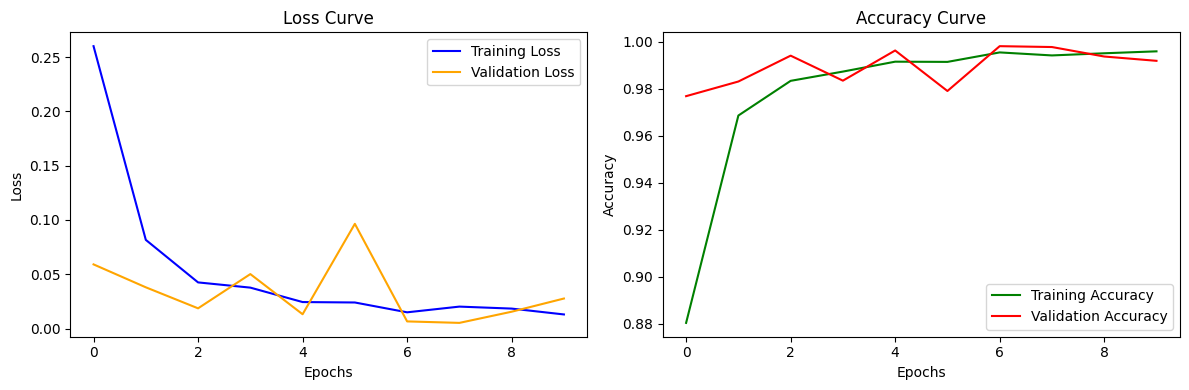

In [36]:
sampled_df = df_ModerateDemented.copy()
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_VeryMildVSModerate.h5", False, 2, False)

In [37]:
train_df, df_MildDemented_test = train_test_split(df_MildDemented, test_size=0.2, random_state=42)
train_df['category'] = 1

Epoch 1/50
2726/2726 [==============================] - 54s 19ms/step - loss: 0.6912 - accuracy: 0.5206 - val_loss: 0.5315 - val_accuracy: 0.7019
Epoch 2/50
2726/2726 [==============================] - 52s 19ms/step - loss: 0.3684 - accuracy: 0.8306 - val_loss: 0.1798 - val_accuracy: 0.9211
Epoch 3/50
2726/2726 [==============================] - 51s 19ms/step - loss: 0.1958 - accuracy: 0.9246 - val_loss: 0.1000 - val_accuracy: 0.9626
Epoch 4/50
2726/2726 [==============================] - 52s 19ms/step - loss: 0.1206 - accuracy: 0.9545 - val_loss: 0.0837 - val_accuracy: 0.9703
Epoch 5/50
2726/2726 [==============================] - 52s 19ms/step - loss: 0.0981 - accuracy: 0.9673 - val_loss: 0.0765 - val_accuracy: 0.9739
Epoch 6/50
2726/2726 [==============================] - 51s 19ms/step - loss: 0.0730 - accuracy: 0.9755 - val_loss: 0.0537 - val_accuracy: 0.9809
Epoch 7/50
2726/2726 [==============================] - 52s 19ms/step - loss: 0.0582 - accuracy: 0.9804 - val_loss: 0.0514 -

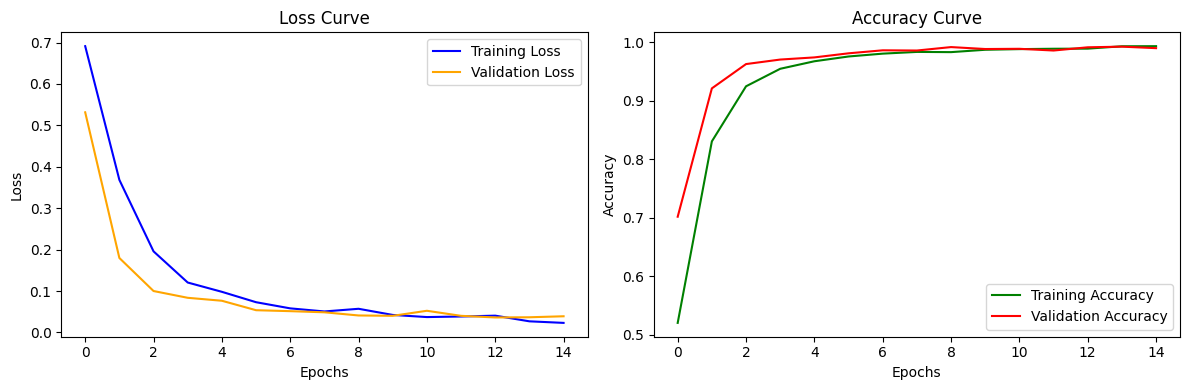

In [38]:
sampled_df = df_ModerateDemented.copy()
sampled_df['category'] = 0

df_train = pd.concat([train_df, sampled_df], ignore_index=True)

process_data__train_and_save_model(df_train, "model_MildVSModerate.h5", True, 2, False)

In [39]:
train_df, df_ModerateDemented_test = train_test_split(df_ModerateDemented, test_size=0.2, random_state=42)

## Models Final Testing

In [40]:
df = pd.concat([df_NonDemented_test, df_VeryMildDemented_test, df_MildDemented_test, df_ModerateDemented_test], ignore_index=True)

df = df.sample(n = len(df) //10).reset_index(drop=True)

In [41]:
Y_True = []

for category in df['category']:
    if category == "NonDemented":
        Y_True.append(0)
    elif category == "VeryMildDemented":
        Y_True.append(1)
    elif category == "MildDemented":
        Y_True.append(2)
    elif category == "ModerateDemented":
        Y_True.append(3)

In [42]:
NonVSVeryMild_model = load_model('model_NonVSVeryMild.h5')
NonVSMild_model = load_model('model_NonVSMild.h5')
NonVSModerate_model = load_model('model_NonVSModerate.h5')

VeryMildVSMild_model = load_model('model_VeryMildVSMild.h5')
VeryMildVSModerate_model = load_model('model_VeryMildVSModerate.h5')

MildVSModerate_model = load_model('model_MildVSModerate.h5')

confidence = {
    'NonVSVeryMild': 0.9264,
    'NonVSMild': 0.9684,
    'NonVSModerate': 0.9947,
    'VeryMildVSMild': 0.9449,
    'VeryMildVSModerate': 0.9952,
    'MildVSModerate': 0.9820
}

In [43]:
def predict_with_thresholds(img):
    img = np.expand_dims(img, axis=0)

    NonVSVeryMild_Predict = float(NonVSVeryMild_model.predict(img, verbose=0))
    NonVSMild_Predict = float(NonVSMild_model.predict(img, verbose=0))
    NonVSModerate_Predict = float(NonVSModerate_model.predict(img, verbose=0))

    VeryMildVSMild_Predict = float(VeryMildVSMild_model.predict(img, verbose=0))
    VeryMildVSModerate_Predict = float(VeryMildVSModerate_model.predict(img, verbose=0))

    MildVSModerate_Predict = float(MildVSModerate_model.predict(img, verbose=0))

    predictionProbabilities = [0, 0, 0, 0]
    predictionProbabilities[0] = ((NonVSVeryMild_Predict * confidence['NonVSVeryMild']) + (NonVSMild_Predict * confidence['NonVSMild']) + (NonVSModerate_Predict * confidence['NonVSModerate'])) / 3
    predictionProbabilities[1] = (((1 - NonVSVeryMild_Predict) * confidence['NonVSVeryMild']) + (VeryMildVSMild_Predict * confidence['VeryMildVSMild']) + (VeryMildVSModerate_Predict * confidence['VeryMildVSModerate'])) / 3
    predictionProbabilities[2] = (((1 - NonVSMild_Predict) * confidence['NonVSMild']) + ((1 - VeryMildVSMild_Predict) * confidence['VeryMildVSMild']) + (MildVSModerate_Predict * confidence['MildVSModerate'])) / 3
    predictionProbabilities[3] = (((1 - NonVSModerate_Predict) * confidence['NonVSModerate']) + ((1 - VeryMildVSModerate_Predict) * confidence['VeryMildVSModerate']) + ((1 - MildVSModerate_Predict) * confidence['MildVSModerate'])) / 3

    maxProb = np.argmax(predictionProbabilities)
    if predictionProbabilities[maxProb] >= 0.8:
        return maxProb
    else:
        return 4

In [47]:
Y_Predict = []
for img in df['processed_image']:
    Y_Predict.append(predict_with_thresholds(img))

Y_True = np.array(Y_True)
Y_Predict = np.array(Y_Predict)

In [48]:
target_names=["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented", "Unsure"]

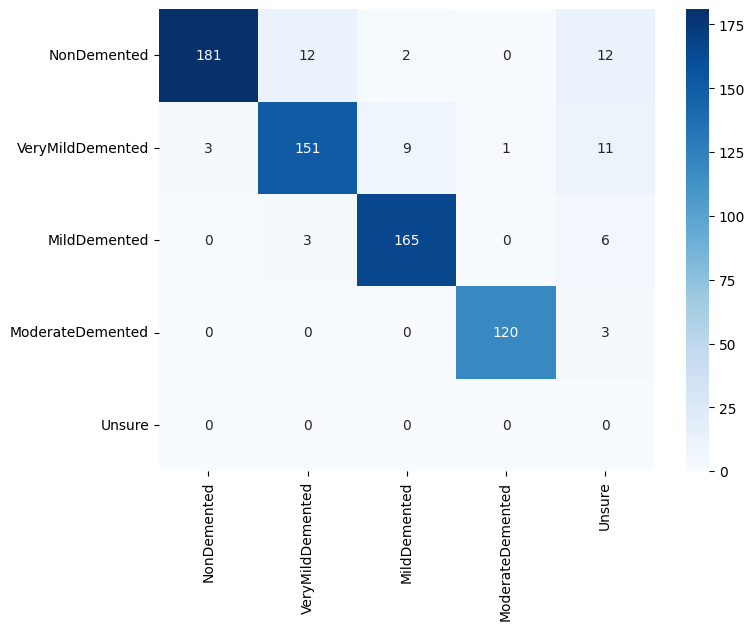

                  precision    recall  f1-score   support

     NonDemented       0.98      0.87      0.93       207
VeryMildDemented       0.91      0.86      0.89       175
    MildDemented       0.94      0.95      0.94       174
ModerateDemented       0.99      0.98      0.98       123
          Unsure       0.00      0.00      0.00         0

        accuracy                           0.91       679
       macro avg       0.76      0.73      0.75       679
    weighted avg       0.95      0.91      0.93       679



C:\Users\Ayush\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ayush\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ayush\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
cm = confusion_matrix(Y_True, Y_Predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = target_names, yticklabels = target_names)
plt.show()

report = classification_report(Y_True, Y_Predict, target_names = target_names)
print(report)